In [1]:
%matplotlib inline
%load_ext line_profiler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
mpl.style.use(['fivethirtyeight', 'figsize'])
_SAVEDIR_ = 'Tex/figures/'
from IPython.display import HTML


def prog_bar(cur_val,max_val,msg = ""):
    import sys
    sys.stdout.write('\r')
    eq = int(np.ceil(np.true_divide(cur_val*100,max_val*5)))
    sys.stdout.write("[{:20s}] {}/{} {:}  ".format('='*eq, cur_val+1,max_val,msg))
    sys.stdout.flush()


[====================] 30/30   

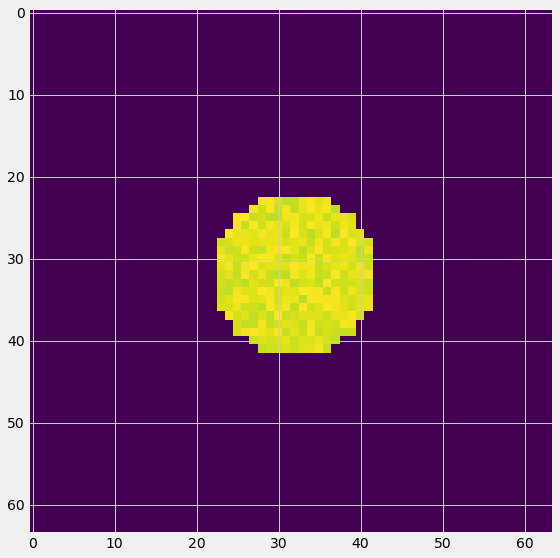

In [32]:
def flip_T(a):
    return np.flipud(a.T)
def calc_macro_f(f):
    #Assumes f at a given time step
    #  this fxn shouldn't be used in the loops as it takes times to create new numpy arrays
    # useful after running for getting macro quantities w/o having the rho,u, and v arrays handy
    u = np.zeros([lx,ly])
    v = np.zeros([lx,ly])
    
    rho = np.sum(f,axis=0)
    for k in range(9):
        u += f[k]*ex[k]
        v += f[k]*ey[k]
    u=u/rho
    v=v/rho
    return rho, u ,v
lx =64
ly = lx
Nsteps = 30
ex=[0,1,0,-1,0 ,1,-1,-1, 1]
ey=[0,0,1,0 ,-1,1, 1,-1,-1]
w = [4./9,1./9,1./9,1./9,1./9,1./36,1./36,1./36,1./36] 
G = -5
cs = 1/np.sqrt(3)
omega = 1

# initialization
f = np.zeros([Nsteps, 9,lx,ly])
u = np.zeros([lx,ly])
v = np.zeros([lx,ly])

rho = np.zeros([lx,ly])
disp_x = lx/2
disp_y = ly/2
y,x = np.ogrid[-disp_x:lx-disp_x,-disp_y:ly-disp_y]
radius = 10
mask = x*x +y*y < radius**2
rho[mask] = 2.4
rho *= 1+.05*(np.random.rand(lx,ly)-.5)*2
rho[mask == 0] = .125
for kk in range(0,9):  
    f[0,kk,:,:] = w[kk]*rho
plt.imshow(rho)

for ts in range(1,Nsteps):
#     print("="*40)
#     print()
#     print(np.sum(rho))

#     prog_bar(ts,Nsteps)
    prog_bar(ts,Nsteps)
    fout = np.copy(f[ts-1])
#     for kk in range(0,9): 
#         f[ts,kk,:,:] = np.roll(fout[kk,:,:],(ex[kk],ey[kk]),(0,1))
    fp = np.copy(f[ts-1])
    for i in range(lx):
        for j in range(ly):
            f[ts,2,i,j] = fp[2,i,j-1]
            f[ts,6,i,j] = fp[6,(i+1)%lx,j-1]
            f[ts,1,i,j] = fp[1,i-1,j]
            f[ts,5,i,j] = fp[5,i-1,j-1]
            f[ts,4,i,j] = fp[4,i,(j+1)%ly]
            f[ts,8,i,j] = fp[8,i-1,(j+1)%ly]
            f[ts,3,i,j] = fp[3,(i+1)%lx,j]
            f[ts,7,i,j] = fp[7,(i+1)%lx,(j+1)%(ly-1)]
            f[ts,0,i,j] = fp[0,i,j]

    # hydrovar
    rho = np.sum(f[ts],axis=0)
#     print(np.sum(rho))

    for j in range(ly):
        for i in range(lx):
            u[i,j] = ( f[ts,1,i,j] - f[ts,3,i,j] + f[ts,5,i,j] -f[ts,6,i,j] - f[ts,7,i,j] + f[ts,8,i,j] ) / rho[i,j]

            v[i,j] = ( f[ts,5,i,j] + f[ts,2,i,j] + f[ts,6,i,j] - f[ts,7,i,j] - f[ts,4,i,j] - f[ts,8,i,j] ) / rho[i,j]
#     print(u)

    psi = np.zeros([lx,ly])
    for i in range(lx):
        for j in range(ly):
            psi[i,j] = 1-np.exp(-rho[i,j])
#             print(psi[i,j])
            
    for i in range(lx):
        for j in range(ly):
            fnnx  = psi[i,j]*(psi[(i+1)%lx,j]-psi[i-1,j])
            fnny  = psi[i,j]*(psi[i,(j+1)%ly]-psi[i,j-1])
            fnnnx = psi[i,j]*((psi[(i+1)%lx,j-1]+psi[(i+1)%lx,(j+1)%ly])
                              -psi[i-1,j-1] - psi[i-1,(j+1)%ly])
            fnnny = psi[i,j]*((psi[(i+1)%lx,(j+1)%ly] + psi[i-1,(j+1)%ly]
                               - psi[i-1,j-1] - psi[(i+1)%lx,j-1]))
#             print((-G*fnnx/9 -G*fnnnx/36)/rho[i,j])
            u[i,j] = u[i,j] -(G*fnnx/9 + G*fnnnx/36)/rho[i,j]
            v[i,j] = v[i,j] -(G*fnny/9 + G*fnnny/36)/rho[i,j]


    # shift equlibrium
#     u += force_x/(omega*rho)
#     v += force_y/(omega*rho)
#     print(u)
    
    #=======================================
    cs2  = 1.00 / 3.00
    cs22 = 2.00 * cs2
    cssq = 2.0 / 9.00
    feq = np.zeros([9,lx,ly])
#     print(np.sum(rho))
#     for k in range(0,9):
#             cu = (1./cs**2)*(ex[k]*u+ey[k]*v)
#             feq = rho*w[k]*(1.+cu+cu**2-(u**2+v**2)/(2*cs**2))
#             f[ts, k, :,:] = f[ts,k,:,:] +(1./omega)*(feq-f[ts,k,:,:])
    for j in range(ly):
        for i in range(lx):
            usq = u[i,j] * u[i,j] 
            vsq = v[i,j] * v[i,j]
            sumsq = (usq + vsq) / cs22 
            sumsq2 = sumsq * (1.00 - cs2) / cs2
            u22 = usq / cssq 
            v22 = vsq / cssq 
            ui = u[i,j] / cs2
            vi = v[i,j] / cs2
            uv = ui * vi 
            rhoij = rho[i,j]



            feq[0,i,j] = (4.0/9.0)*rhoij*(1.00 - sumsq)

            feq[1,i,j] = (1.0/9.0)*rhoij*(1.00 - sumsq + u22 + ui)
            feq[2,i,j] = (1.0/9.0)*rhoij*(1.00 - sumsq + v22 + vi)
            feq[3,i,j] = (1.0/9.0)*rhoij*(1.00 - sumsq + u22 - ui)
            feq[4,i,j] = (1.0/9.0)*rhoij*(1.00 - sumsq + v22 - vi)

            feq[5,i,j] = (1.0/36.0)*rhoij*(1.00 + sumsq2 + ui + vi + uv)
            feq[6,i,j] = (1.0/36.0)*rhoij*(1.00 + sumsq2 - ui + vi - uv)
            feq[7,i,j] = (1.0/36.0)*rhoij*(1.00 + sumsq2 - ui - vi + uv)
            feq[8,i,j] = (1.0/36.0)*rhoij*(1.00 + sumsq2 + ui - vi - uv)

    for i in range(lx):
        for j in range(ly):
            for k in range(9):
                f[ts,k,i,j] = feq[k,i,j]
    
    # hydrovar
#     print(np.sum(rho))

    rho = np.sum(f[ts],axis=0)
#     print(np.sum(rho))

#     rho = np.zeros([lx,ly])
#     for i in range(lx):
#         for j in range(ly):
#             for k in range(9):
#                 rho[i,j] = rho[i,j]+f[ts,k,i,j]
    for j in range(ly):
        for i in range(lx):
            u[i,j] = ( f[ts,1,i,j] - f[ts,3,i,j] + f[ts,5,i,j] -f[ts,6,i,j] - f[ts,7,i,j] + f[ts,8,i,j] ) / rho[i,j]

            v[i,j] = ( f[ts,5,i,j] + f[ts,2,i,j] + f[ts,6,i,j] - f[ts,7,i,j] - f[ts,4,i,j] - f[ts,8,i,j] ) / rho[i,j]


#     equilibrium(u, v, rho, f, ts)




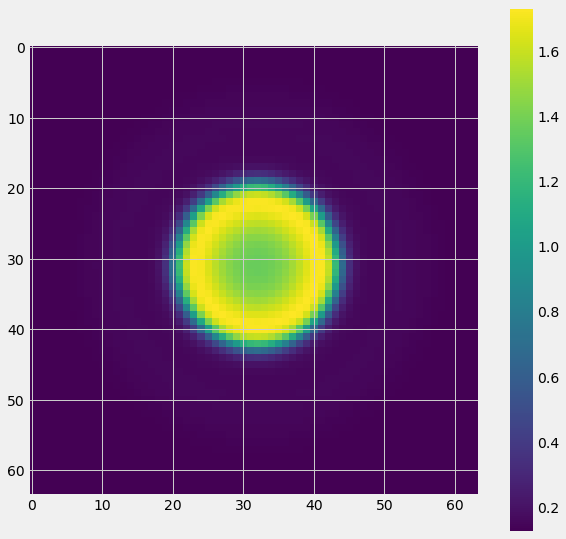

In [33]:
a = calc_macro_f(f[-1])[0]
# a[a>2.4]=-1
plt.imshow(flip_T(a))
plt.colorbar()
plt.show()

[====================] 1000/1000   

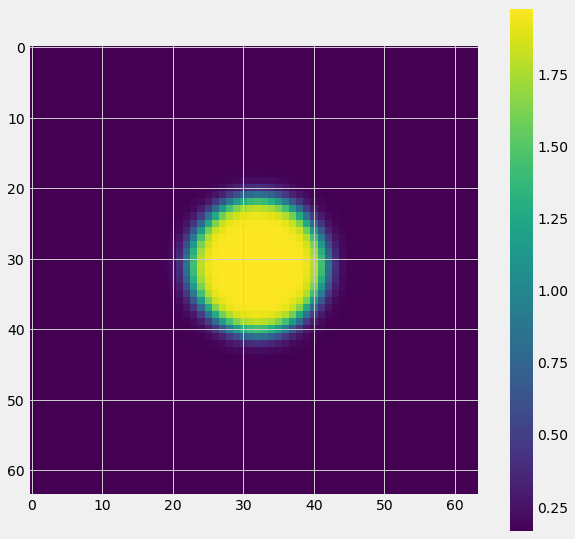

In [2]:
def flip_T(a):
    return np.flipud(a.T)
def calc_macro_f(f):
    #Assumes f at a given time step
    #  this fxn shouldn't be used in the loops as it takes times to create new numpy arrays
    # useful after running for getting macro quantities w/o having the rho,u, and v arrays handy
    u = np.zeros([lx,ly])
    v = np.zeros([lx,ly])
    
    rho = np.sum(f,axis=0)
    for k in range(9):
        u += f[k]*ex[k]
        v += f[k]*ey[k]
    u=u/rho
    v=v/rho
    return rho, u ,v
lx =64
ly = lx
Nsteps = 1000
ex=[0,1,0,-1,0 ,1,-1,-1, 1]
ey=[0,0,1,0 ,-1,1, 1,-1,-1]
w = [4./9,1./9,1./9,1./9,1./9,1./36,1./36,1./36,1./36] 
G = -5
cs = 1/np.sqrt(3)
omega = 1
rho_psi =1

# initialization
f = np.zeros([Nsteps, 9,lx,ly])
u = np.zeros([lx,ly])
v = np.zeros([lx,ly])

rho = np.zeros([lx,ly])
disp_x = lx/2
disp_y = ly/2
y,x = np.ogrid[-disp_x:lx-disp_x,-disp_y:ly-disp_y]
radius = 10
mask = x*x +y*y < radius**2
rho[mask] = 2.4
rho *= 1+.05*(np.random.rand(lx,ly)-.5)*2
rho[mask == 0] = .125
for kk in range(0,9):  
    f[0,kk,:,:] = w[kk]*rho
plt.imshow(rho)

for ts in range(1,Nsteps):
#     print("="*40)
#     print()
#     print(np.sum(rho))

#     prog_bar(ts,Nsteps)
    prog_bar(ts,Nsteps)
    fout = np.copy(f[ts-1])
    for kk in range(0,9): 
        f[ts,kk,:,:] = np.roll(fout[kk,:,:],(ex[kk],ey[kk]),(0,1))


#     rho = np.sum(f[ts],axis=0)

#     for j in range(ly):
#         for i in range(lx):
#             u[i,j] = ( f[ts,1,i,j] - f[ts,3,i,j] + f[ts,5,i,j] -f[ts,6,i,j] - f[ts,7,i,j] + f[ts,8,i,j] ) / rho[i,j]

#             v[i,j] = ( f[ts,5,i,j] + f[ts,2,i,j] + f[ts,6,i,j] - f[ts,7,i,j] - f[ts,4,i,j] - f[ts,8,i,j] ) / rho[i,j]
    u[:,:] = 0
    v[:,:] = 0
    
    rho = np.sum(f[ts],axis=0)
    for k in range(9):
        u += f[ts,k]*ex[k]
        v += f[ts, k]*ey[k]
    u=u/rho
    v=v/rho
#     psi = np.zeros([lx,ly])
#     for i in range(lx):
#         for j in range(ly):
#             psi[i,j] = 1-np.exp(-rho[i,j])
#             print(psi[i,j])
            
#     for i in range(lx):
#         for j in range(ly):
#             fnnx  = psi[i,j]*(psi[(i+1)%lx,j]-psi[i-1,j])
#             fnny  = psi[i,j]*(psi[i,(j+1)%ly]-psi[i,j-1])
#             fnnnx = psi[i,j]*((psi[(i+1)%lx,j-1]+psi[(i+1)%lx,(j+1)%ly])
#                               -psi[i-1,j-1] - psi[i-1,(j+1)%ly])
#             fnnny = psi[i,j]*((psi[(i+1)%lx,(j+1)%ly] + psi[i-1,(j+1)%ly]
#                                - psi[i-1,j-1] - psi[(i+1)%lx,j-1]))
# #             print((-G*fnnx/9 -G*fnnnx/36)/rho[i,j])
#             u[i,j] = u[i,j] -(G*fnnx/9 + G*fnnnx/36)/rho[i,j]
#             v[i,j] = v[i,j] -(G*fnny/9 + G*fnnny/36)/rho[i,j]
    psi = rho_psi*(1-np.exp(-rho/rho_psi))
    # a negative roll velocity implied i+1

    f_x = psi*(np.roll(psi,(-1,0),(0,1))-np.roll(psi,(1,0),(0,1)))
    f_y = psi*(np.roll(psi,(0,-1),(0,1))-np.roll(psi,(0,1),(0,1)))

    f2_x = psi*(np.roll(psi,(-1,1),(0,1))+np.roll(psi,(-1,-1),(0,1))
                -np.roll(psi,(1,1),(0,1))-np.roll(psi,(1,-1),(0,1)))


    f2_y = psi*(np.roll(psi,(-1,-1),(0,1))+np.roll(psi,(1,-1),(0,1))
                -np.roll(psi,(1,1),(0,1))-np.roll(psi,(-1,1),(0,1)))

    force_x = -G*(f_x/9+f2_x/36)
    force_y = -G*(f_y/9+f2_y/36)

    # shift equlibrium
    u += force_x/(omega*rho)
    v += force_y/(omega*rho)
#     print(u)
    
    #=======================================
    cs2  = 1.00 / 3.00
    cs22 = 2.00 * cs2
    cssq = 2.0 / 9.00
    feq = np.zeros([9,lx,ly])
#     print(np.sum(rho))
#     for k in range(0,9):
#             cu = (1./cs**2)*(ex[k]*u+ey[k]*v)
#             feq = rho*w[k]*(1.+cu+cu**2-(u**2+v**2)/(2*cs**2))
#             f[ts, k, :,:] = f[ts,k,:,:] +(1./omega)*(feq-f[ts,k,:,:])
    new = True
    if not new:
        for j in range(ly):
            for i in range(lx):
                usq = u[i,j] * u[i,j] 
                vsq = v[i,j] * v[i,j]
                sumsq = (usq + vsq) / cs22 
                sumsq2 = sumsq * (1.00 - cs2) / cs2
                u22 = usq / cssq 
                v22 = vsq / cssq 
                ui = u[i,j] / cs2
                vi = v[i,j] / cs2
                uv = ui * vi 
                rhoij = rho[i,j]



                feq[0,i,j] = (4.0/9.0)*rhoij*(1.00 - sumsq)

                feq[1,i,j] = (1.0/9.0)*rhoij*(1.00 - sumsq + u22 + ui)
                feq[2,i,j] = (1.0/9.0)*rhoij*(1.00 - sumsq + v22 + vi)
                feq[3,i,j] = (1.0/9.0)*rhoij*(1.00 - sumsq + u22 - ui)
                feq[4,i,j] = (1.0/9.0)*rhoij*(1.00 - sumsq + v22 - vi)

                feq[5,i,j] = (1.0/36.0)*rhoij*(1.00 + sumsq2 + ui + vi + uv)
                feq[6,i,j] = (1.0/36.0)*rhoij*(1.00 + sumsq2 - ui + vi - uv)
                feq[7,i,j] = (1.0/36.0)*rhoij*(1.00 + sumsq2 - ui - vi + uv)
                feq[8,i,j] = (1.0/36.0)*rhoij*(1.00 + sumsq2 + ui - vi - uv)
    if new:
        usq = u*u
        vsq = v*v
        sumsq = (usq+vsq)/cs22
        sumsq2 = sumsq*(1-cs2)/cs2
        u22 = usq/cssq
        v22 = vsq/cssq
        ui = u/cs2
        vi = v/cs2
        uv = ui*vi
        feq[0] = (4.0/9.0)*rho*(1.00 - sumsq)

        feq[1] = (1.0/9.0)*rho*(1.00 - sumsq + u22 + ui)
        feq[2] = (1.0/9.0)*rho*(1.00 - sumsq + v22 + vi)
        feq[3] = (1.0/9.0)*rho*(1.00 - sumsq + u22 - ui)
        feq[4] = (1.0/9.0)*rho*(1.00 - sumsq + v22 - vi)

        feq[5] = (1.0/36.0)*rho*(1.00 + sumsq2 + ui + vi + uv)
        feq[6] = (1.0/36.0)*rho*(1.00 + sumsq2 - ui + vi - uv)
        feq[7] = (1.0/36.0)*rho*(1.00 + sumsq2 - ui - vi + uv)
        feq[8] = (1.0/36.0)*rho*(1.00 + sumsq2 + ui - vi - uv)

    for k in range(9):
        f[ts,k] = feq[k]
    

#     rho = np.sum(f[ts],axis=0)
#     for j in range(ly):
#         for i in range(lx):
#             u[i,j] = ( f[ts,1,i,j] - f[ts,3,i,j] + f[ts,5,i,j] -f[ts,6,i,j] - f[ts,7,i,j] + f[ts,8,i,j] ) / rho[i,j]

#             v[i,j] = ( f[ts,5,i,j] + f[ts,2,i,j] + f[ts,6,i,j] - f[ts,7,i,j] - f[ts,4,i,j] - f[ts,8,i,j] ) / rho[i,j]


#     equilibrium(u, v, rho, f, ts)


a = calc_macro_f(f[-1])[0]
# a[a>2.4]=-1
plt.imshow(flip_T(a))
plt.colorbar()
plt.show()

In [57]:
def v1():
    for j in range(ly):
        for i in range(lx):
            usq = u[i,j] * u[i,j] 
            vsq = v[i,j] * v[i,j]
            sumsq = (usq + vsq) / cs22 
            sumsq2 = sumsq * (1.00 - cs2) / cs2
            u22 = usq / cssq 
            v22 = vsq / cssq 
            ui = u[i,j] / cs2
            vi = v[i,j] / cs2
            uv = ui * vi 
            rhoij = rho[i,j]



            feq[0,i,j] = (4.0/9.0)*rhoij*(1.00 - sumsq)

            feq[1,i,j] = (1.0/9.0)*rhoij*(1.00 - sumsq + u22 + ui)
            feq[2,i,j] = (1.0/9.0)*rhoij*(1.00 - sumsq + v22 + vi)
            feq[3,i,j] = (1.0/9.0)*rhoij*(1.00 - sumsq + u22 - ui)
            feq[4,i,j] = (1.0/9.0)*rhoij*(1.00 - sumsq + v22 - vi)

            feq[5,i,j] = (1.0/36.0)*rhoij*(1.00 + sumsq2 + ui + vi + uv)
            feq[6,i,j] = (1.0/36.0)*rhoij*(1.00 + sumsq2 - ui + vi - uv)
            feq[7,i,j] = (1.0/36.0)*rhoij*(1.00 + sumsq2 - ui - vi + uv)
            feq[8,i,j] = (1.0/36.0)*rhoij*(1.00 + sumsq2 + ui - vi - uv)
    return feq
def v2():
    usq = u*u
    vsq = v*v
    sumsq = (usq+vsq)/cs22
    sumsq2 = sumsq*(1-cs2)/cs2
    u22 = usq/cssq
    v22 = vsq/cssq
    ui = u/cs2
    v22 = v/cs2
    uv = u*v
    feq[0] = (4.0/9.0)*rho*(1.00 - sumsq)

    feq[1] = (1.0/9.0)*rho*(1.00 - sumsq + u22 + ui)
    feq[2] = (1.0/9.0)*rho*(1.00 - sumsq + v22 + vi)
    feq[3] = (1.0/9.0)*rho*(1.00 - sumsq + u22 - ui)
    feq[4] = (1.0/9.0)*rho*(1.00 - sumsq + v22 - vi)

    feq[5] = (1.0/36.0)*rho*(1.00 + sumsq2 + ui + vi + uv)
    feq[6] = (1.0/36.0)*rho*(1.00 + sumsq2 - ui + vi - uv)
    feq[7] = (1.0/36.0)*rho*(1.00 + sumsq2 - ui - vi + uv)
    feq[8] = (1.0/36.0)*rho*(1.00 + sumsq2 + ui - vi - uv)
    return feq

In [58]:
v1()-v2()

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ..., 
       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0., 

In [60]:
%%timeit
a = v1()

10 loops, best of 3: 30 ms per loop


In [61]:
%%timeit
a = v2()

The slowest run took 5.31 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 227 µs per loop


In [62]:
5*200*10**-6

0.001

[====================] 500/500   

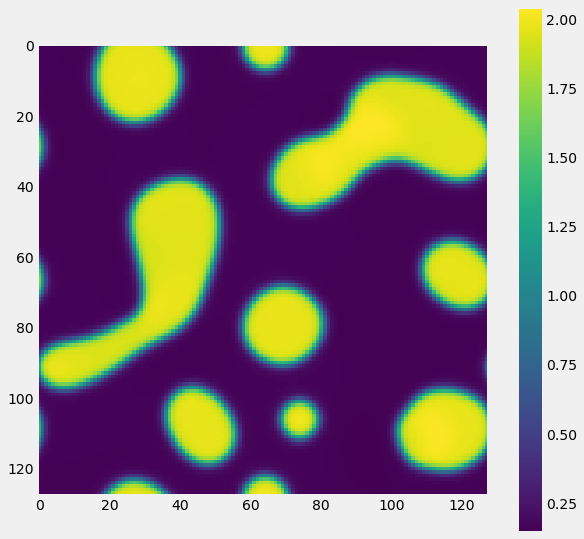

In [175]:
def flip_T(a):
    return np.flipud(a.T)
def calc_macro_f(f):
    #Assumes f at a given time step
    #  this fxn shouldn't be used in the loops as it takes times to create new numpy arrays
    # useful after running for getting macro quantities w/o having the rho,u, and v arrays handy
    u = np.zeros([lx,ly])
    v = np.zeros([lx,ly])
    
    rho = np.sum(f,axis=0)
    for k in range(9):
        u += f[k]*ex[k]
        v += f[k]*ey[k]
    u=u/rho
    v=v/rho
    return rho, u ,v
def equilibrium(rho,u,v):
    feq = np.zeros([9,lx,ly])
    usq = u*u
    vsq = v*v
    sumsq = (usq+vsq)/cs22
    sumsq2 = sumsq*(1-cs2)/cs2
    u22 = usq/cssq
    v22 = vsq/cssq
    ui = u/cs2
    vi = v/cs2
    uv = ui*vi
    feq[0] = (4.0/9.0)*rho*(1.00 - sumsq)

    feq[1] = (1.0/9.0)*rho*(1.00 - sumsq + u22 + ui)
    feq[2] = (1.0/9.0)*rho*(1.00 - sumsq + v22 + vi)
    feq[3] = (1.0/9.0)*rho*(1.00 - sumsq + u22 - ui)
    feq[4] = (1.0/9.0)*rho*(1.00 - sumsq + v22 - vi)

    feq[5] = (1.0/36.0)*rho*(1.00 + sumsq2 + ui + vi + uv)
    feq[6] = (1.0/36.0)*rho*(1.00 + sumsq2 - ui + vi - uv)
    feq[7] = (1.0/36.0)*rho*(1.00 + sumsq2 - ui - vi + uv)
    feq[8] = (1.0/36.0)*rho*(1.00 + sumsq2 + ui - vi - uv)
    return feq
def calc_force(rho):
    psi = rho_psi*(1-np.exp(-rho/rho_psi))
    # a negative roll velocity implied i+1

    f_x = psi*(np.roll(psi,(-1,0),(0,1))-np.roll(psi,(1,0),(0,1)))
    f_y = psi*(np.roll(psi,(0,-1),(0,1))-np.roll(psi,(0,1),(0,1)))

    f2_x = psi*(np.roll(psi,(-1,1),(0,1))+np.roll(psi,(-1,-1),(0,1))
                -np.roll(psi,(1,1),(0,1))-np.roll(psi,(1,-1),(0,1)))


    f2_y = psi*(np.roll(psi,(-1,-1),(0,1))+np.roll(psi,(1,-1),(0,1))
                -np.roll(psi,(1,1),(0,1))-np.roll(psi,(-1,1),(0,1)))

    force_x = -G*(f_x/9+f2_x/36)
    force_y = -G*(f_y/9+f2_y/36)
    return force_x, force_y

lx =128
ly = lx
Nsteps = 500
ex=[0,1,0,-1,0 ,1,-1,-1, 1]
ey=[0,0,1,0 ,-1,1, 1,-1,-1]
w = [4./9,1./9,1./9,1./9,1./9,1./36,1./36,1./36,1./36] 
G = -5
cs = 1/np.sqrt(3)
omega = 1
rho_psi =1
rho_in=.69

# initialization
f = np.zeros([Nsteps, 9,lx,ly])
u = np.zeros([lx,ly])
v = np.zeros([lx,ly])

rho = np.zeros([lx,ly])
# disp_x = lx/2
# disp_y = ly/2
# y,x = np.ogrid[-disp_x:lx-disp_x,-disp_y:ly-disp_y]
# radius = 20
# mask = x +y*y < radius**2
# rho[mask] = 2.4
# rho *= 1+.05*(np.random.rand(lx,ly)-.5)*2
# rho[mask == 0] = .125

rho = rho_in *(1+.01*np.random.rand(lx,ly))

# rho = np.zeros([lx,ly])
# disp_x = lx/2
# disp_y = 0
# y,x = np.ogrid[-disp_x:lx-disp_x,-disp_y:ly-disp_y]
# radius = 60
# mask = x*x +y*y < radius**2
# mask2 = x*x +y*y < (radius*.5)**2
# rho[mask] = 2.4
# rho *= 1+.05*(np.random.rand(lx,ly)-.5)*2
# rho[mask == 0] = 1
# rho[mask2 == 1] = .125
for kk in range(0,9):  
    f[0,kk,:,:] = w[kk]*rho
# plt.imshow(rho)

for ts in range(1,Nsteps):
#     print("="*40)
#     print()
#     print(np.sum(rho))

#     prog_bar(ts,Nsteps)
    prog_bar(ts,Nsteps)
    fout = np.copy(f[ts-1])
    for kk in range(0,9): 
        f[ts,kk,:,:] = np.roll(fout[kk,:,:],(ex[kk],ey[kk]),(0,1))

    u[:,:] = 0
    v[:,:] = 0
    
    rho = np.sum(f[ts],axis=0)
    for k in range(9):
        u += f[ts,k]*ex[k]
        v += f[ts, k]*ey[k]
    u=u/rho
    v=v/rho


    force_x, force_y = calc_force(rho)
    u += force_x/(omega*rho)
    v += force_y/(omega*rho)
    
    #=======================================
    cs2  = 1.00 / 3.00
    cs22 = 2.00 * cs2
    cssq = 2.0 / 9.00
    feq = equilibrium(rho,u,v)
    for k in range(9):
        f[ts,k] = feq[k]
    

a = calc_macro_f(f[-1])[0]
plt.imshow(flip_T(a))
plt.grid('off')
plt.colorbar()
plt.show()

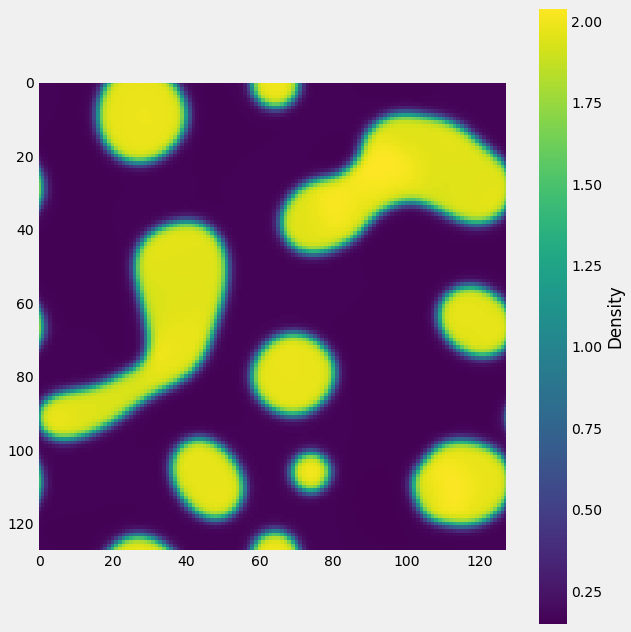

In [177]:
mpl.style.use()
plt.imshow(flip_T(a))
plt.grid('off')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Density')
plt.tight_layout()
plt.savefig(_SAVEDIR_+"muphase_randinit.png")

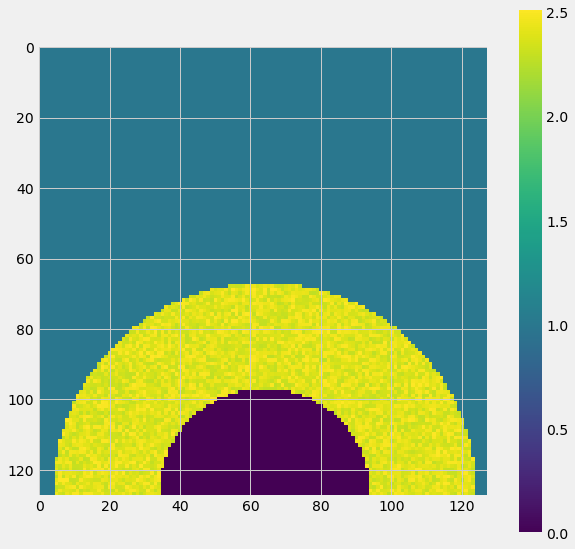

In [29]:
rho = np.zeros([lx,ly])
disp_x = lx/2
disp_y = 0
y,x = np.ogrid[-disp_x:lx-disp_x,-disp_y:ly-disp_y]
radius = 60
mask = x*x +y*y < radius**2
mask2 = x*x +y*y < (radius*.5)**2
rho[mask] = 2.4
rho *= 1+.05*(np.random.rand(lx,ly)-.5)*2
rho[mask == 0] = 1
rho[mask2 == 1] = 0
# rho[ 40<x<100] = 5

plt.imshow(flip_T(rho))
plt.colorbar()


In [34]:
for i in range(0,1000,5):
    plt.imshow(flip_T(calc_macro_f(f[i])[0]))
    plt.grid('off')
    plt.colorbar()
    plt.savefig('figures/donut_'+str(i).zfill(5)+'.png')
    plt.close()

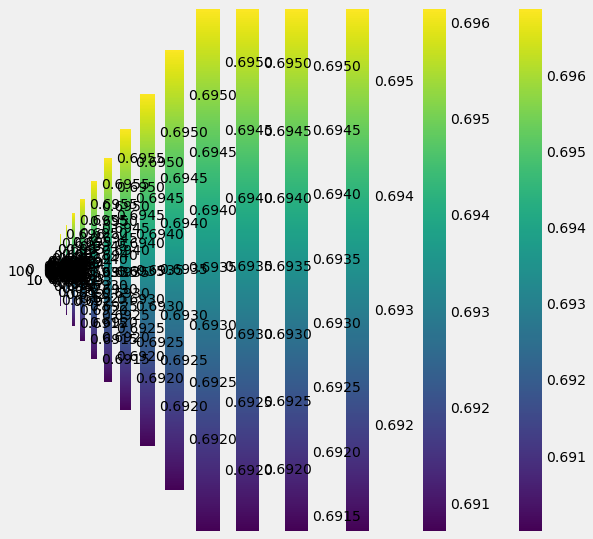

In [105]:
for i in range(0,25,1):
    plt.imshow(flip_T(calc_macro_f(f[i])[0]))
    plt.grid('off')
    plt.colorbar()
    plt.savefig('figures/fig2_'+str(i).zfill(5)+'.png')

In [173]:
a = calc_macro_f(f[500])[0]
plt.imshow(flip_T(a))
plt.grid('off')
plt.colorbar()
plt.tightlayout()
plt.show()

IndexError: index 500 is out of bounds for axis 0 with size 400

/home/ianhi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/ianhi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


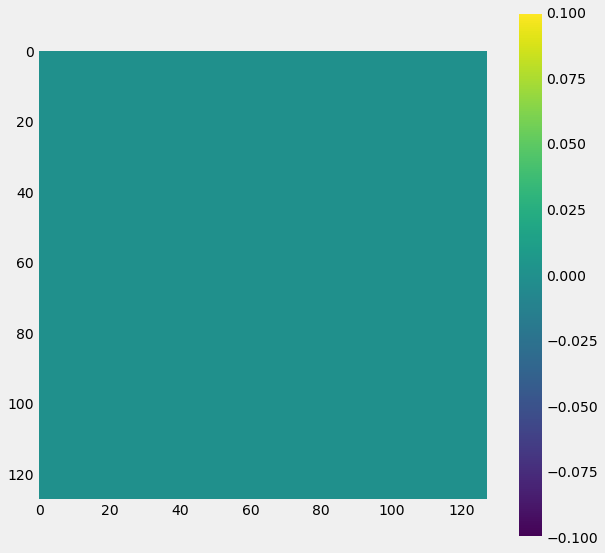

In [36]:
def flip_T(a):
    return np.flipud(a.T)
def calc_macro_f(f):
    #Assumes f at a given time step
    #  this fxn shouldn't be used in the loops as it takes times to create new numpy arrays
    # useful after running for getting macro quantities w/o having the rho,u, and v arrays handy
    u = np.zeros([lx,ly])
    v = np.zeros([lx,ly])
    
    rho = np.sum(f,axis=0)
    for k in range(9):
        u += f[k]*ex[k]
        v += f[k]*ey[k]
    u=u/rho
    v=v/rho
    return rho, u ,v
def equilibrium(rho,u,v):
    feq = np.zeros([9,lx,ly])
    usq = u*u
    vsq = v*v
    sumsq = (usq+vsq)/cs22
    sumsq2 = sumsq*(1-cs2)/cs2
    u22 = usq/cssq
    v22 = vsq/cssq
    ui = u/cs2
    vi = v/cs2
    uv = ui*vi
    feq[0] = (4.0/9.0)*rho*(1.00 - sumsq)

    feq[1] = (1.0/9.0)*rho*(1.00 - sumsq + u22 + ui)
    feq[2] = (1.0/9.0)*rho*(1.00 - sumsq + v22 + vi)
    feq[3] = (1.0/9.0)*rho*(1.00 - sumsq + u22 - ui)
    feq[4] = (1.0/9.0)*rho*(1.00 - sumsq + v22 - vi)

    feq[5] = (1.0/36.0)*rho*(1.00 + sumsq2 + ui + vi + uv)
    feq[6] = (1.0/36.0)*rho*(1.00 + sumsq2 - ui + vi - uv)
    feq[7] = (1.0/36.0)*rho*(1.00 + sumsq2 - ui - vi + uv)
    feq[8] = (1.0/36.0)*rho*(1.00 + sumsq2 + ui - vi - uv)
    return feq
def calc_force(rho):
    psi = rho_psi*(1-np.exp(-rho/rho_psi))
    # a negative roll velocity implied i+1

    f_x = psi*(np.roll(psi,(-1,0),(0,1))-np.roll(psi,(1,0),(0,1)))
    f_y = psi*(np.roll(psi,(0,-1),(0,1))-np.roll(psi,(0,1),(0,1)))

    f2_x = psi*(np.roll(psi,(-1,1),(0,1))+np.roll(psi,(-1,-1),(0,1))
                -np.roll(psi,(1,1),(0,1))-np.roll(psi,(1,-1),(0,1)))


    f2_y = psi*(np.roll(psi,(-1,-1),(0,1))+np.roll(psi,(1,-1),(0,1))
                -np.roll(psi,(1,1),(0,1))-np.roll(psi,(-1,1),(0,1)))

    force_x = -G*(f_x/9+f2_x/36)
    force_y = -G*(f_y/9+f2_y/36)
    return force_x, force_y

lx =128
ly = lx
Nsteps = 2000
ex=[0,1,0,-1,0 ,1,-1,-1, 1]
ey=[0,0,1,0 ,-1,1, 1,-1,-1]
w = [4./9,1./9,1./9,1./9,1./9,1./36,1./36,1./36,1./36] 
G = -5
cs = 1/np.sqrt(3)
omega = 1
rho_psi =1
rho_in=.69

# initialization
f = np.zeros([Nsteps, 9,lx,ly])
u = np.zeros([lx,ly])
v = np.zeros([lx,ly])

# rho = np.zeros([lx,ly])
# disp_x = lx/2
# disp_y = ly/2
# y,x = np.ogrid[-disp_x:lx-disp_x,-disp_y:ly-disp_y]
# radius = 20
# mask = x +y*y < radius**2
# rho[mask] = 2.4
# rho *= 1+.05*(np.random.rand(lx,ly)-.5)*2
# rho[mask == 0] = .125

# rho = rho_in *(1+.01*np.random.rand(lx,ly))

rho = np.zeros([lx,ly])
disp_x = lx/2
disp_y = 0
y,x = np.ogrid[-disp_x:lx-disp_x,-disp_y:ly-disp_y]
radius = 60
mask = x*x +y*y < radius**2
mask2 = x*x +y*y < (radius*.5)**2
rho[mask] = 2.4
rho *= 1+.05*(np.random.rand(lx,ly)-.5)*2
rho[mask == 0] = 1
rho[mask2 == 1] = .125
for kk in range(0,9):  
    f[0,kk,:,:] = w[kk]*rho
# plt.imshow(rho)
def fast(rho, Nsteps):
    f = np.zeros([Nsteps, 9,lx,ly])
    u = np.zeros([lx,ly])
    v = np.zeros([lx,ly])

    for kk in range(0,9):  
        f[0,kk,:,:] = w[kk]*rho
    for ts in range(1,Nsteps):
    #     print("="*40)
    #     print()
    #     print(np.sum(rho))

    #     prog_bar(ts,Nsteps)
        prog_bar(ts,Nsteps)
        fout = np.copy(f[ts-1])
        for kk in range(0,9): 
            f[ts,kk,:,:] = np.roll(fout[kk,:,:],(ex[kk],ey[kk]),(0,1))

        u[:,:] = 0
        v[:,:] = 0

        rho = np.sum(f[ts],axis=0)
        for k in range(9):
            u += f[ts,k]*ex[k]
            v += f[ts, k]*ey[k]
        u=u/rho
        v=v/rho


        force_x, force_y = calc_force(rho)
        u += force_x/(omega*rho)
        v += force_y/(omega*rho)

        #=======================================
        cs2  = 1.00 / 3.00
        cs22 = 2.00 * cs2
        cssq = 2.0 / 9.00
        feq = equilibrium(rho,u,v)
        for k in range(9):
            f[ts,k] = feq[k]
    return f
    

a = calc_macro_f(f[-1])[0]
plt.imshow(flip_T(a))
plt.grid('off')
plt.colorbar()
plt.show()

In [58]:
def equilibrium(rho,u,v):
    feq = np.zeros([9,lx,ly])
    usq = u*u
    vsq = v*v
    sumsq = (usq+vsq)/cs22
    sumsq2 = sumsq*(1-cs2)/cs2
    u22 = usq/cssq
    v22 = vsq/cssq
    ui = u/cs2
    vi = v/cs2
    uv = ui*vi
    feq[0] = (4.0/9.0)*rho*(1.00 - sumsq)

    feq[1] = (1.0/9.0)*rho*(1.00 - sumsq + u22 + ui)
    feq[2] = (1.0/9.0)*rho*(1.00 - sumsq + v22 + vi)
    feq[3] = (1.0/9.0)*rho*(1.00 - sumsq + u22 - ui)
    feq[4] = (1.0/9.0)*rho*(1.00 - sumsq + v22 - vi)

    feq[5] = (1.0/36.0)*rho*(1.00 + sumsq2 + ui + vi + uv)
    feq[6] = (1.0/36.0)*rho*(1.00 + sumsq2 - ui + vi - uv)
    feq[7] = (1.0/36.0)*rho*(1.00 + sumsq2 - ui - vi + uv)
    feq[8] = (1.0/36.0)*rho*(1.00 + sumsq2 + ui - vi - uv)
    return feq

def fast(rho, Nsteps):
    f = np.zeros([Nsteps, 9,lx,ly])
    u = np.zeros([lx,ly])
    v = np.zeros([lx,ly])

    for kk in range(0,9):  
        f[0,kk,:,:] = w[kk]*rho
    for ts in range(1,Nsteps):
    #     print("="*40)
    #     print()
    #     print(np.sum(rho))

    #     prog_bar(ts,Nsteps)
#         prog_bar(ts,Nsteps)
        fout = np.copy(f[ts-1])
        for kk in range(0,9): 
            f[ts,kk,:,:] = np.roll(fout[kk,:,:],(ex[kk],ey[kk]),(0,1))

        u[:,:] = 0
        v[:,:] = 0

        rho = np.sum(f[ts],axis=0)
        for k in range(9):
            u += f[ts,k]*ex[k]
            v += f[ts, k]*ey[k]
        u=u/rho
        v=v/rho


        force_x, force_y = calc_force(rho)
        u += force_x/(omega*rho)
        v += force_y/(omega*rho)

        #=======================================
        cs2  = 1.00 / 3.00
        cs22 = 2.00 * cs2
        cssq = 2.0 / 9.00
        feq = equilibrium(rho,u,v)
        for k in range(9):
            f[ts,k] = feq[k]
    return f
def init_rho():
    rho= np.zeros([lx,ly])
    disp_x = lx/2
    disp_y = 0
    y,x = np.ogrid[-disp_x:lx-disp_x,-disp_y:ly-disp_y]
    radius = 60
    mask = x*x +y*y < radius**2
    mask2 = x*x +y*y < (radius*.5)**2
    rho[mask] = 2.4
    rho *= 1+.05*(np.random.rand(lx,ly)-.5)*2
    rho[mask == 0] = 1
    rho[mask2 == 1] = .125
    return rho
rho_init = init_rho()

In [59]:
%%timeit
f = fast(rho_init,400)

1 loop, best of 3: 1.81 s per loop


In [105]:
import numexpr as ne

def equilibrium2(rho,u,v):
    feq = np.zeros([9,lx,ly])
    usq = u*u
    vsq = v*v
    sumsq = (usq+vsq)/cs22
    sumsq2 = sumsq*(1-cs2)/cs2
    u22 = usq/cssq
    v22 = vsq/cssq
    ui = u/cs2
    vi = v/cs2
    uv = ui*vi
    feq[0] = (4.0/9.0)*rho*(1.00 - sumsq)

    feq[1] = (1.0/9.0)*rho*(1.00 - sumsq + u22 + ui)
    feq[2] = (1.0/9.0)*rho*(1.00 - sumsq + v22 + vi)
    feq[3] = (1.0/9.0)*rho*(1.00 - sumsq + u22 - ui)
    feq[4] = (1.0/9.0)*rho*(1.00 - sumsq + v22 - vi)

    feq[5] = (1.0/36.0)*rho*(1.00 + sumsq2 + ui + vi + uv)
    feq[6] = (1.0/36.0)*rho*(1.00 + sumsq2 - ui + vi - uv)
    feq[7] = (1.0/36.0)*rho*(1.00 + sumsq2 - ui - vi + uv)
    feq[8] = (1.0/36.0)*rho*(1.00 + sumsq2 + ui - vi - uv)
    return feq
def calc_force2(rho):
    psi = ne.evaluate('rho_psi*(1-exp(-rho/rho_psi))')
    # a negative roll velocity implied i+1

    f_x = psi*(np.roll(psi,(-1,0),(0,1))-np.roll(psi,(1,0),(0,1)))
    f_y = psi*(np.roll(psi,(0,-1),(0,1))-np.roll(psi,(0,1),(0,1)))

    f2_x = psi*(np.roll(psi,(-1,1),(0,1))+np.roll(psi,(-1,-1),(0,1))-np.roll(psi,(1,1),(0,1))-np.roll(psi,(1,-1),(0,1)))


    f2_y = psi*(np.roll(psi,(-1,-1),(0,1))+np.roll(psi,(1,-1),(0,1))
                -np.roll(psi,(1,1),(0,1))-np.roll(psi,(-1,1),(0,1)))

    force_x = -G*(f_x/9+f2_x/36)
    force_y = -G*(f_y/9+f2_y/36)
    return force_x, force_y
def fast2(rho, Nsteps):
    f = np.zeros([Nsteps, 9,lx,ly])
    u = np.zeros([lx,ly])
    v = np.zeros([lx,ly])

    for kk in range(0,9):  
        f[0,kk,:,:] = w[kk]*rho
        
    for ts in range(1,Nsteps):
        if ts%100==0:
            print(ts)
#         prog_bar(ts,Nsteps)
        fout = np.copy(f[ts-1])
        for kk in range(0,9): 
            f[ts,kk,:,:] = np.roll(fout[kk,:,:],(ex[kk],ey[kk]),(0,1))

        u[:,:] = 0
        v[:,:] = 0

        rho = np.sum(f[ts],axis=0)
        for k in range(9):
            u += f[ts,k]*ex[k]
            v += f[ts, k]*ey[k]
        u=u/rho
        v=v/rho


        force_x, force_y = calc_force2(rho)
        u += force_x/(omega*rho)
        v += force_y/(omega*rho)

        #=======================================
        cs2  = 1.00 / 3.00
        cs22 = 2.00 * cs2
        cssq = 2.0 / 9.00
        feq = equilibrium2(rho,u,v)
        for k in range(9):
            f[ts,k] = feq[k]
    return f
%timeit a = fast2(rho_init,1000)

100
200
300
400
500
600
700
800
900
100
200
300
400
500
600
700
800
900
100
200
300
400
500
600
700
800
900
100
200
300
400
500
600
700
800
900
1 loop, best of 3: 3.86 s per loop


In [91]:
lx = 128
ly = 128

In [92]:
%%timeit
f = fast(rho_init,400)

1 loop, best of 3: 1.74 s per loop


In [100]:
%timeit f = fast2(rho_init,1000)

1 loop, best of 3: 3.64 s per loop


In [81]:
%lprun -f equilibrium2 a = fast2(rho_init,400)

In [90]:
%lprun -f calc_force2 a = fast2(rho_init,400)

In [98]:
%%timeit
%%bash
./muphase

Process is interrupted.
  Number of steps
  Number of steps between printing profile
  Number of steps between performing diagnostics
 dt
 viscosity
  Coupling gnn
 Insert rhopsi
 Applied force  (.TRUE. or .FALSE.) ?
  Initial density
  Initial X velocity component
  Initial Y velocity component
  Final velocity for the Poise force
  Linear obstacle ?
  File for output: 5 chars
  read populations dump (0 or 1)
 *******************************************************
          Lattice BGK model, 2D with 9 velocities
              multiphse code with 2-belt EoS
 *******************************************************
   developed and released by Prof. GIACOMO FALCUCCI, PhD
         for AC274 Class at HARVARD University
                          2017
 Number of cells :         128 *         128
 Nsteps :        5000
 Relaxation frequency :   1.0000000000000000     
 Coupling gnn :  -5.0000000000000000     
 Coupling gnnn :   0.0000000000000000     
 Applied force : T
 Initial velocity for

Process is interrupted.
Process is interrupted.
The slowest run took 4.72 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 9.7 s per loop


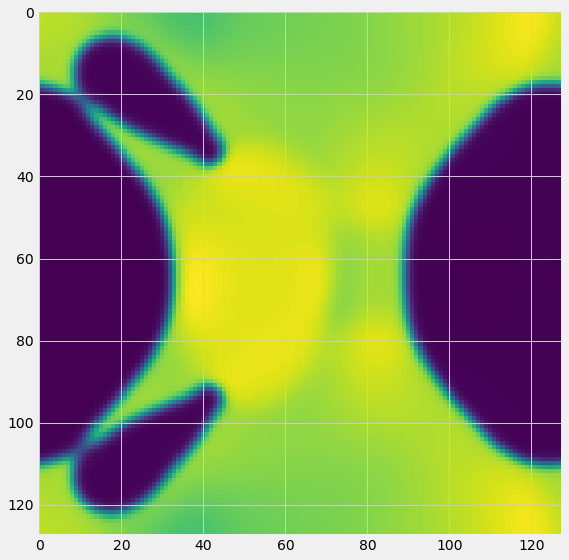

In [108]:
plt.imshow(calc_macro_f(a[-1])[0])

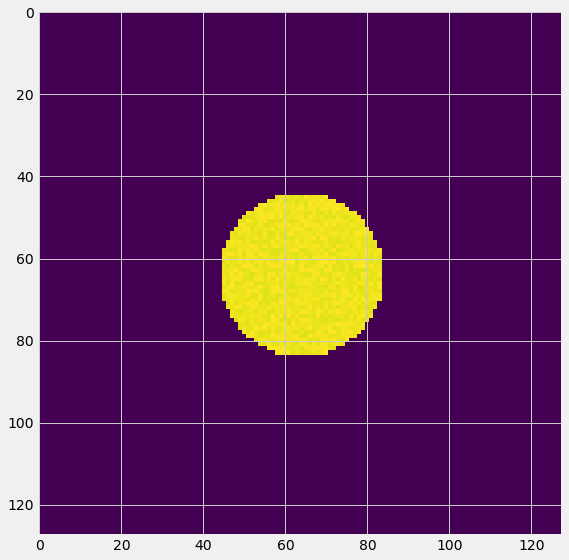

In [109]:
rho= np.zeros([lx,ly])
disp_x = lx/2
disp_y = ly/2
y,x = np.ogrid[-disp_x:lx-disp_x,-disp_y:ly-disp_y]
radius = 20
mask = x*x +y*y < radius**2
rho[mask] = 2.4
rho *= 1+.05*(np.random.rand(lx,ly)-.5)
rho[mask == 0] = .125
plt.imshow(rho)

In [110]:
a = fast2(rho,1000)

100
200
300
400
500
600
700
800
900


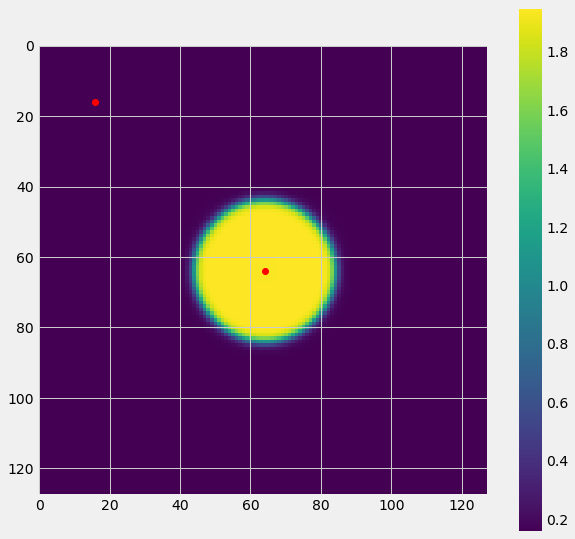

In [117]:
rho = calc_macro_f(a[-1])[0]
plt.imshow(rho)
plt.colorbar()
plt.plot([lx/2,lx/8],[ly/2,ly/8],'ro')

In [120]:
plt.plot(np.array(rho[:,ly/2]))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [122]:
type(rho)

numpy.ndarray

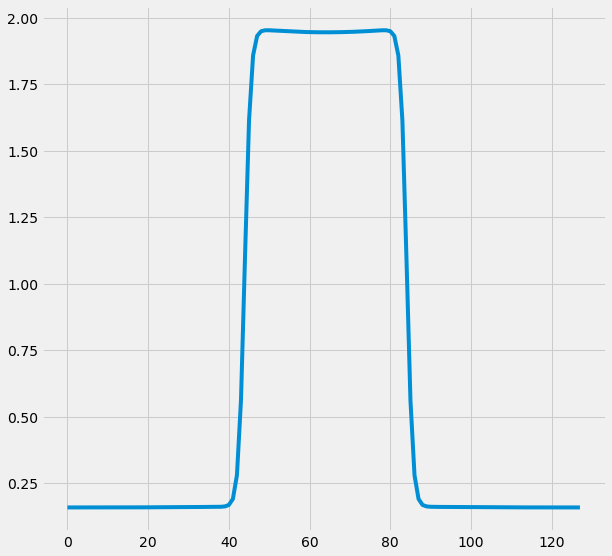

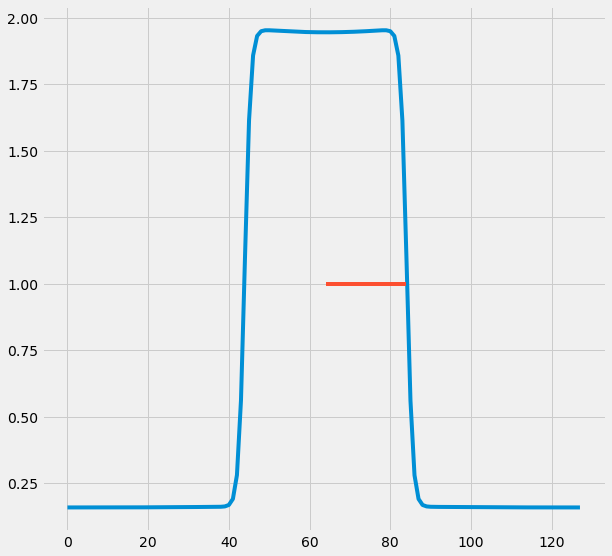

In [166]:
target = 1
idx = np.argmin(np.abs(rho[:,int(ly/2)] - target))
plt.plot(rho[:,int(ly/2)])
plt.plot([ly/2,idx],[1,1])

In [134]:
def determine_radius(rho):
    rho_cent = rho[int(lx/2),int(ly/2)]
    rho_out = rho[int(lx/8),int(ly/8)]
    target = (rho_cent+rho_out)/2
    idx = np.argmin(np.abs(rho[:,int(ly/2)] - target))
    return np.abs(lx/2-idx)
determine_radius(rho)

20.0

In [164]:
rho_psi = 1
def pressure(rho):
    psi = rho_psi*(1-np.exp(-rho/rho_psi))
    press = cs2*(rho+.5*G*psi**2)
    pmax = np.max(press)
    pmin = np.min(press)
    return pmin, pmax, press
a = pressure(rho)
print(a)
a[-1][int(lx/2),int(ly/2)]

(-0.0076947627937683869, 0.04417262837415227, array([[ 0.03460498,  0.0346058 ,  0.03460826, ...,  0.03461238,
         0.03460828,  0.03460582],
       [ 0.03460581,  0.03460662,  0.03460908, ...,  0.03461319,
         0.0346091 ,  0.03460664],
       [ 0.03460827,  0.03460908,  0.03461152, ...,  0.03461562,
         0.03461155,  0.03460909],
       ..., 
       [ 0.03461237,  0.03461318,  0.0346156 , ...,  0.03461964,
         0.03461561,  0.03461319],
       [ 0.03460828,  0.03460909,  0.03461153, ...,  0.03461562,
         0.03461155,  0.0346091 ],
       [ 0.03460581,  0.03460663,  0.03460908, ...,  0.03461319,
         0.03460911,  0.03460664]]))


0.036278610126334154

In [149]:
a[-1][int(lx/2),int(ly/2)]

-29.290367027896099

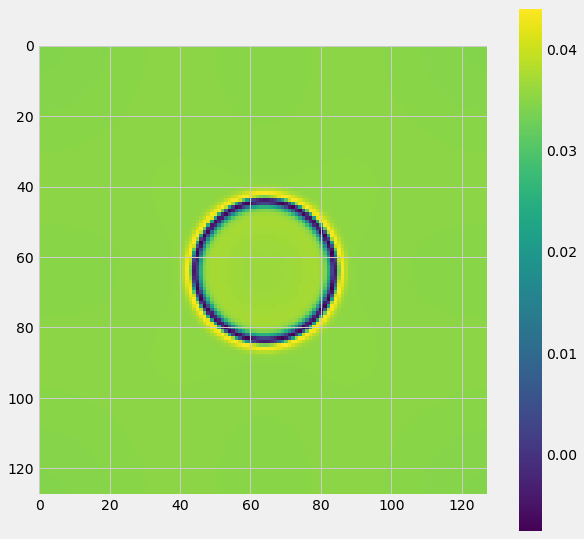

In [165]:
plt.imshow(a[-1])
plt.colorbar()
plt.show()

In [163]:
rho_psi = 7
print(rho_psi*(1-np.exp(-rho/rho_psi)))

[[ 0.15420501  0.1542113   0.15423014 ...,  0.1542618   0.15423034
   0.1542114 ]
 [ 0.15421134  0.15421761  0.15423641 ...,  0.15426803  0.15423663
   0.15421771]
 [ 0.15423021  0.15423645  0.15425516 ...,  0.15428663  0.15425538
   0.15423656]
 ..., 
 [ 0.15426171  0.15426791  0.15428648 ...,  0.15431757  0.15428662
   0.15426798]
 [ 0.15423028  0.15423653  0.15425525 ...,  0.15428664  0.15425541
   0.15423661]
 [ 0.15421137  0.15421765  0.15423646 ...,  0.15426804  0.15423664
   0.15421774]]


In [162]:
np.exp(rho/rho_psi)

array([[ 1.02252551,  1.02252645,  1.02252926, ...,  1.02253399,
         1.02252929,  1.02252646],
       [ 1.02252645,  1.02252739,  1.0225302 , ...,  1.02253492,
         1.02253023,  1.02252741],
       [ 1.02252927,  1.0225302 ,  1.022533  , ...,  1.0225377 ,
         1.02253303,  1.02253022],
       ..., 
       [ 1.02253398,  1.0225349 ,  1.02253768, ...,  1.02254232,
         1.0225377 ,  1.02253491],
       [ 1.02252928,  1.02253022,  1.02253301, ...,  1.0225377 ,
         1.02253304,  1.02253023],
       [ 1.02252646,  1.0225274 ,  1.02253021, ...,  1.02253492,
         1.02253023,  1.02252741]])

In [168]:
b = np.random.rand(23)
b

array([ 0.60226075,  0.78390008,  0.88460109,  0.71621921,  0.30152989,
        0.71728132,  0.58154388,  0.04041984,  0.86605482,  0.22411489,
        0.61720157,  0.61049612,  0.52549437,  0.08071887,  0.72475459,
        0.57445051,  0.6291671 ,  0.76964883,  0.90598546,  0.85170238,
        0.17531345,  0.6379318 ,  0.47810127])

In [169]:
np.save("somename",b)

In [172]:
np.load("somename.npy")

array([ 0.60226075,  0.78390008,  0.88460109,  0.71621921,  0.30152989,
        0.71728132,  0.58154388,  0.04041984,  0.86605482,  0.22411489,
        0.61720157,  0.61049612,  0.52549437,  0.08071887,  0.72475459,
        0.57445051,  0.6291671 ,  0.76964883,  0.90598546,  0.85170238,
        0.17531345,  0.6379318 ,  0.47810127])